In [1]:
import os, re, random, shutil
from pathlib import Path


In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2025-12-16 00:41:38--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-12-16 00:41:38--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  40.2MB/s    in 1.5s    

2025-12-16 00:41:39 (40.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
!pip install dlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for dlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [41 lines of output]
      running bdist_wheel
      running build
      running build_ext
      
      
                         CMake is not installed on your system!
      
          Or it is possible some broken copy of cmake is installed on your system.
          It is unfortunately very common for python package managers to include
          broken copies of cmake.  So if the error above this refers to some file
          path to a cmake file inside a python or anaconda or miniconda path then you
          should delete that broken copy of cmake from your computer.
      
          Instead, please get an official copy of cmake from one o

In [4]:
!apt-get update
!apt-get install -y cmake
!pip install dlib


Get:1 http://deb.debian.org/debian trixie InRelease [140 kB]
Get:2 http://deb.debian.org/debian trixie-updates InRelease [47.3 kB]
Get:3 http://deb.debian.org/debian-security trixie-security InRelease [43.4 kB]
Get:4 http://deb.debian.org/debian trixie/main amd64 Packages [9670 kB]
Get:5 http://deb.debian.org/debian-security trixie-security/main amd64 Packages [84.8 kB]
Fetched 9986 kB in 1s (12.3 MB/s)                        
Reading package lists... Done
N: Repository 'http://deb.debian.org/debian trixie InRelease' changed its 'Version' value from '13.1' to '13.2'
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cmake-data libarchive13t64 libjsoncpp26 librhash1 libuv1t64
Suggested packages:
  cmake-doc cmake-format elpa-cmake-mode ninja-build lrzip
The following NEW packages will be installed:
  cmake cmake-data libarchive13t64 libjsoncpp26 librhash1 libuv1t64
0 upgraded, 6 newly in

In [5]:
import os, cv2
import numpy as np
import dlib
from pathlib import Path

# Load dlib's face detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # لازم الملف ده

def align_face(image, desired_left_eye=(0.35, 0.35), desired_face_width=224, desired_face_height=224):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) == 0:
        return cv2.resize(image, (desired_face_width, desired_face_height))
    
    rect = rects[0]
    shape = predictor(gray, rect)
    shape = np.array([[p.x, p.y] for p in shape.parts()])
    
    left_eye_center = shape[36:42].mean(axis=0)
    right_eye_center = shape[42:48].mean(axis=0)
    
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX))
    
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
    scale = desired_dist / dist
    
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) / 2,
                   (left_eye_center[1] + right_eye_center[1]) / 2)
    
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
    tX = desired_face_width * 0.5
    tY = desired_face_height * desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])
    
    aligned_face = cv2.warpAffine(image, M, (desired_face_width, desired_face_height),
                                  flags=cv2.INTER_CUBIC)
    return aligned_face

# مجلدات
raw_dir = Path("/kaggle/input/ffffff/Final_data_raw")  # الصور الأصلية
aligned_dir = Path("/kaggle/working/Final_data_aligned")
aligned_dir.mkdir(exist_ok=True)

# تطبيق alignment على كل الصور
for person_folder in raw_dir.iterdir():
    if not person_folder.is_dir():
        continue
    aligned_person_dir = aligned_dir / person_folder.name
    aligned_person_dir.mkdir(exist_ok=True)
    for img_path in person_folder.glob("*"):
        image = cv2.imread(str(img_path))
        if image is None:
            continue
        aligned_face = align_face(image)
        cv2.imwrite(str(aligned_person_dir / img_path.name), aligned_face)

print("✅ All images aligned")


✅ All images aligned


In [6]:
import random, shutil

random.seed(42)

subset_dir = Path("/kaggle/working/Final_data_splitAligned")
train_dir = subset_dir / "train"
val_dir   = subset_dir / "val"

for d in [subset_dir, train_dir, val_dir]:
    d.mkdir(exist_ok=True)

all_persons = sorted([p for p in aligned_dir.iterdir() if p.is_dir()])
selected_persons = random.sample(all_persons, 50)

val_ratio = 0.2

for person_folder in selected_persons:
    images = list(person_folder.glob("*"))
    if len(images) < 50:
        continue
    images = random.sample(images, 50)
    random.shuffle(images)
    
    n_val = int(len(images) * val_ratio)
    val_images = images[:n_val]
    train_images = images[n_val:]
    
    train_person = train_dir / person_folder.name
    val_person   = val_dir / person_folder.name
    train_person.mkdir(exist_ok=True)
    val_person.mkdir(exist_ok=True)
    
    for img in train_images:
        shutil.copy2(img, train_person / img.name)
    for img in val_images:
        shutil.copy2(img, val_person / img.name)

print("✅ Dataset split into train/val")


✅ Dataset split into train/val


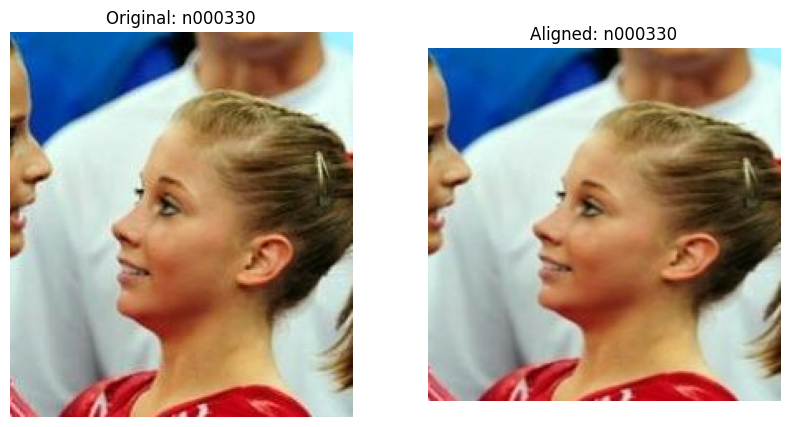

In [7]:
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# مجلد الصور الأصلية قبل الـ alignment
raw_dir = Path("/kaggle/input/ffffff/Final_data_raw")  

# مجلد train بعد الـ alignment والـ split
aligned_train_dir = Path("/kaggle/working/Final_data_splitAligned/train")

# اختيار شخص عشوائي من train
all_persons = sorted([p for p in aligned_train_dir.iterdir() if p.is_dir()])
person_folder = random.choice(all_persons)


# اختيار صورة عشوائية من الشخص بعد الـ alignment
aligned_images = list(person_folder.glob("*"))
aligned_img_path = random.choice(aligned_images)

# اسم الصورة عشان نجيبها من الـ raw
img_name = aligned_img_path.name
raw_img_path = raw_dir / person_folder.name / img_name

# قراءة الصور
raw_image = cv2.imread(str(raw_img_path))
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

aligned_image = cv2.imread(str(aligned_img_path))
aligned_image = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)

# عرض الصور جنب بعض
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(raw_image)
plt.title(f"Original: {person_folder.name}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aligned_image)
plt.title(f"Aligned: {person_folder.name}")
plt.axis("off")

plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

train_dir = Path("/kaggle/working/Final_data_splitAligned/train")
val_dir   = Path("/kaggle/working/Final_data_splitAligned/val")

classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
NUM_CLASSES = len(classes)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

print("Classes:", NUM_CLASSES)


/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 2000 images belonging to 50 classes.
Found 500 images belonging to 50 classes.
Classes: 50


In [9]:
print(train_gen.class_indices)
print(val_gen.class_indices)

{'n000003': 0, 'n000008': 1, 'n000010': 2, 'n000038': 3, 'n000043': 4, 'n000047': 5, 'n000052': 6, 'n000056': 7, 'n000065': 8, 'n000067': 9, 'n000079': 10, 'n000090': 11, 'n000091': 12, 'n000092': 13, 'n000094': 14, 'n000107': 15, 'n000114': 16, 'n000141': 17, 'n000150': 18, 'n000151': 19, 'n000161': 20, 'n000171': 21, 'n000174': 22, 'n000179': 23, 'n000201': 24, 'n000212': 25, 'n000218': 26, 'n000222': 27, 'n000233': 28, 'n000240': 29, 'n000251': 30, 'n000257': 31, 'n000266': 32, 'n000269': 33, 'n000271': 34, 'n000279': 35, 'n000303': 36, 'n000307': 37, 'n000310': 38, 'n000313': 39, 'n000314': 40, 'n000321': 41, 'n000322': 42, 'n000323': 43, 'n000330': 44, 'n000334': 45, 'n000346': 46, 'n000348': 47, 'n000351': 48, 'n000353': 49}
{'n000003': 0, 'n000008': 1, 'n000010': 2, 'n000038': 3, 'n000043': 4, 'n000047': 5, 'n000052': 6, 'n000056': 7, 'n000065': 8, 'n000067': 9, 'n000079': 10, 'n000090': 11, 'n000091': 12, 'n000092': 13, 'n000094': 14, 'n000107': 15, 'n000114': 16, 'n000141': 17

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=5)
    ]
)

model.summary()


2025-12-16 01:06:12.239116: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,856,434 (91.01 MB)

 Trainable params: 268,722 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "best_resnet50_model.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [12]:
print(val_gen.image_shape)  # لو بتستخدم ImageDataGenerator


(224, 224, 3)


In [13]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=5)
    ]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.0180 - loss: 4.1861 - top_k_categorical_accuracy: 0.0975 - val_accuracy: 0.0200 - val_loss: 4.0928 - val_top_k_categorical_accuracy: 0.1060
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - accuracy: 0.0235 - loss: 4.1226 - top_k_categorical_accuracy: 0.1100 - val_accuracy: 0.0220 - val_loss: 4.0365 - val_top_k_categorical_accuracy: 0.0980
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.0225 - loss: 4.0750 - top_k_categorical_accuracy: 0.1045 - val_accuracy: 0.0220 - val_loss: 4.0009 - val_top_k_categorical_accuracy: 0.1000
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - accuracy: 0.0215 - loss: 4.0455 - top_k_categorical_accuracy: 0.1045 - val_accuracy: 0.0220 - val_loss: 3.9754 - val_top_k_categorical_accuracy: 0.1080
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.0195 - loss: 4.0115 - top_k_categorical_accuracy: 0.0965 - val_accuracy: 0.0220 - val_loss: 3.9